# Waste-Assist Classification¶

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

2021-08-24 00:19:22.497280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-24 00:19:22.497331: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocessing the Training set

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
X_train = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2678 images belonging to 7 classes.


In [3]:
X_train.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

# Preprocessing the Test set

In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)
y_train = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 73 images belonging to 7 classes.


# Building the CNN

In [5]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def initialize_model():
    '''instanciate and return the CNN architecture'''
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3), padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))

    return model

In [6]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

2021-08-24 00:19:25.779292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-24 00:19:25.779396: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-24 00:19:25.779425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BM2AJIC): /proc/driver/nvidia/version does not exist
2021-08-24 00:19:25.779678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Compiling and Training the CNN

In [7]:
from tensorflow.keras import optimizers

def compile_model(model):
    '''return a compiled model suited for the cifar tasks'''
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics='accuracy')
    return model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping


model = compile_model(model)

es = EarlyStopping(patience=5, verbose=2)

history = model.fit(X_train, validation_data = y_train, 
                    callbacks=[es], 
                    epochs=100, 
                    batch_size=32)

2021-08-24 00:19:26.757746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-24 00:19:26.758396: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394460000 Hz


Epoch 1/100
84/84 [==============================] - 13s 153ms/step - loss: 1.8222 - accuracy: 0.2509 - val_loss: 1.7327 - val_accuracy: 0.3288
Epoch 2/100
84/84 [==============================] - 12s 141ms/step - loss: 1.5624 - accuracy: 0.3865 - val_loss: 1.6991 - val_accuracy: 0.3288
Epoch 3/100
84/84 [==============================] - 13s 153ms/step - loss: 1.4698 - accuracy: 0.4137 - val_loss: 1.6206 - val_accuracy: 0.4384
Epoch 4/100
84/84 [==============================] - 32s 377ms/step - loss: 1.3848 - accuracy: 0.4548 - val_loss: 1.5449 - val_accuracy: 0.4658
Epoch 5/100
84/84 [==============================] - 14s 162ms/step - loss: 1.3166 - accuracy: 0.4925 - val_loss: 1.6283 - val_accuracy: 0.4932
Epoch 6/100
84/84 [==============================] - 12s 136ms/step - loss: 1.2862 - accuracy: 0.5127 - val_loss: 1.4665 - val_accuracy: 0.5479
Epoch 7/100
84/84 [==============================] - 12s 144ms/step - loss: 1.2545 - accuracy: 0.5321 - val_loss: 1.5078 - val_accuracy:

In [9]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

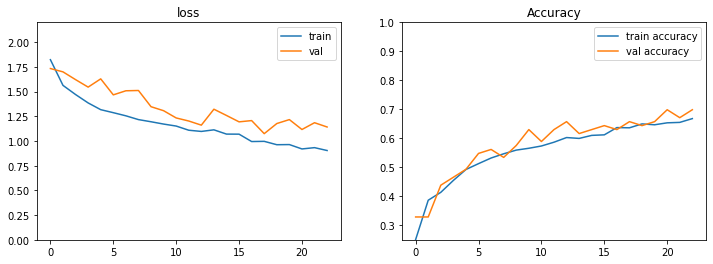

In [10]:
plot_history(history)
plt.show()

# Making a single prediction

In [11]:
from keras.preprocessing import image

test_image = image.load_img('dataset/single_prediction/plastic_image.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)
X_train.class_indices

[[0. 0. 1. 0. 0. 0. 0.]]


{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [12]:
def prediction():
    for key, value in X_train.class_indices.items():
        if result[0][value] == 1:
            return key
prediction()

'glass'